In [1]:
# =========================
# 1. Setup and data loading
# =========================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For forecasting / modeling
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Display options
pd.set_option('display.float_format', lambda x: f'{x:,.0f}')

# Load the data
file_path = "colorado_motor_vehicle_sales.csv"  # update if needed
df = pd.read_csv(file_path)

print("First 5 rows:")
print(df.head())

print("\nInfo:")
print(df.info())

print("\nSummary stats:")
print(df.describe(include='all'))


First 5 rows:
   year  quarter              county      sales
0  2008        1               Adams  231609000
1  2008        1            Arapahoe  550378000
2  2008        1  Boulder/Broomfield  176771000
3  2008        1              Denver  200103000
4  2008        1             Douglas   93259000

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   year     501 non-null    int64 
 1   quarter  501 non-null    int64 
 2   county   501 non-null    object
 3   sales    501 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 15.8+ KB
None

Summary stats:
        year  quarter county       sales
count    501      501    501         501
unique   NaN      NaN     17         NaN
top      NaN      NaN  Adams         NaN
freq     NaN      NaN     32         NaN
mean   2,012        3    NaN 176,058,483
std        2        1    NaN 164,205,510
min   

In [2]:
# =======================
# 2. Basic data cleaning
# =======================

# Standardize column names
df.columns = df.columns.str.lower().str.strip()

# Check for missing values
print("\nMissing values per column:")
print(df.isna().sum())

# Drop completely empty rows if any
df = df.dropna(how="all")

# If there are missing sales, you can decide to drop or impute
# Here we simply drop rows with missing 'sales'
df = df.dropna(subset=['sales'])

# Ensure dtypes are correct
df['year'] = df['year'].astype(int)
df['quarter'] = df['quarter'].astype(int)
df['sales'] = df['sales'].astype(float)

# Strip whitespace in county names
df['county'] = df['county'].str.strip()

print("\nCleaned data preview:")
print(df.head())


Missing values per column:
year       0
quarter    0
county     0
sales      0
dtype: int64

Cleaned data preview:
   year  quarter              county       sales
0  2008        1               Adams 231,609,000
1  2008        1            Arapahoe 550,378,000
2  2008        1  Boulder/Broomfield 176,771,000
3  2008        1              Denver 200,103,000
4  2008        1             Douglas  93,259,000


In [3]:
# ===================================
# 3. Feature engineering for analysis
# ===================================

# Create a period index if useful: e.g., year-quarter as a string
df['year_quarter'] = df['year'].astype(str) + "Q" + df['quarter'].astype(str)

# Optionally create a time index starting at 0 for the earliest quarter
df = df.sort_values(['year', 'quarter'])
df['time_index'] = (df['year'] - df['year'].min()) * 4 + (df['quarter'] - df['quarter'].min())

print("\nWith engineered features:")
print(df.head())



With engineered features:
   year  quarter              county       sales year_quarter  time_index
0  2008        1               Adams 231,609,000       2008Q1           0
1  2008        1            Arapahoe 550,378,000       2008Q1           0
2  2008        1  Boulder/Broomfield 176,771,000       2008Q1           0
3  2008        1              Denver 200,103,000       2008Q1           0
4  2008        1             Douglas  93,259,000       2008Q1           0



Yearly total sales:
   year          sales
0  2008  8,965,561,000
1  2009  7,652,500,000
2  2010  8,556,088,000
3  2011 12,170,441,000
4  2012 10,960,876,000
5  2013 12,000,615,000
6  2014 13,392,487,000
7  2015 14,506,732,000


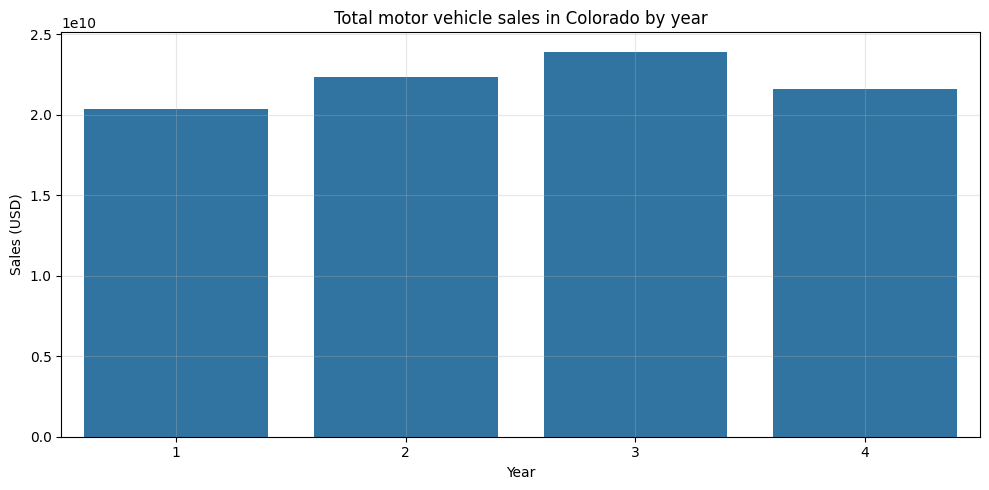

In [11]:
# =========================
# 4. Exploratory data analysis
# =========================

# 4.1 Overall sales by year (sum across counties)
yearly_sales = df.groupby('year')['sales'].sum().reset_index()
print("\nYearly total sales:")
print(yearly_sales)

plt.figure(figsize=(10, 5))
sns.barplot(
    data=quarterly_sales,
    x='quarter',
    y='sales'
)
plt.title("Total motor vehicle sales in Colorado by year")
plt.xlabel("Year")
plt.ylabel("Sales (USD)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



Total sales by quarter (all years combined):
   quarter          sales
0        1 20,376,846,000
1        2 22,343,294,000
2        3 23,914,934,000
3        4 21,570,226,000


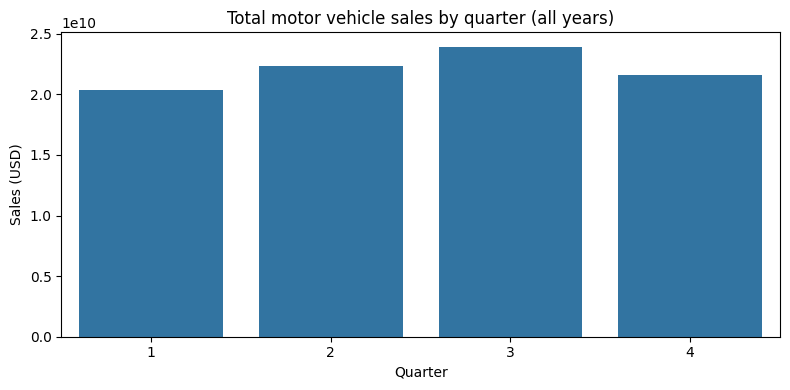

In [12]:
# 4.2 Sales by quarter (aggregated over all years)
quarterly_sales = df.groupby('quarter')['sales'].sum().reset_index()
print("\nTotal sales by quarter (all years combined):")
print(quarterly_sales)

plt.figure(figsize=(8, 4))
sns.barplot(
    data=quarterly_sales,
    x='quarter',
    y='sales'
)
plt.title("Total motor vehicle sales by quarter (all years)")
plt.xlabel("Quarter")
plt.ylabel("Sales (USD)")
plt.tight_layout()
plt.show()



Top 10 counties by total sales:
           county          sales
1        Arapahoe 20,142,323,000
7         El Paso 11,926,044,000
10      Jefferson  9,058,407,000
0           Adams  8,902,115,000
5          Denver  6,763,613,000
12        Larimer  5,344,367,000
16           Weld  5,086,889,000
2         Boulder  4,742,532,000
15  Rest of State  3,582,170,000
6         Douglas  3,236,493,000


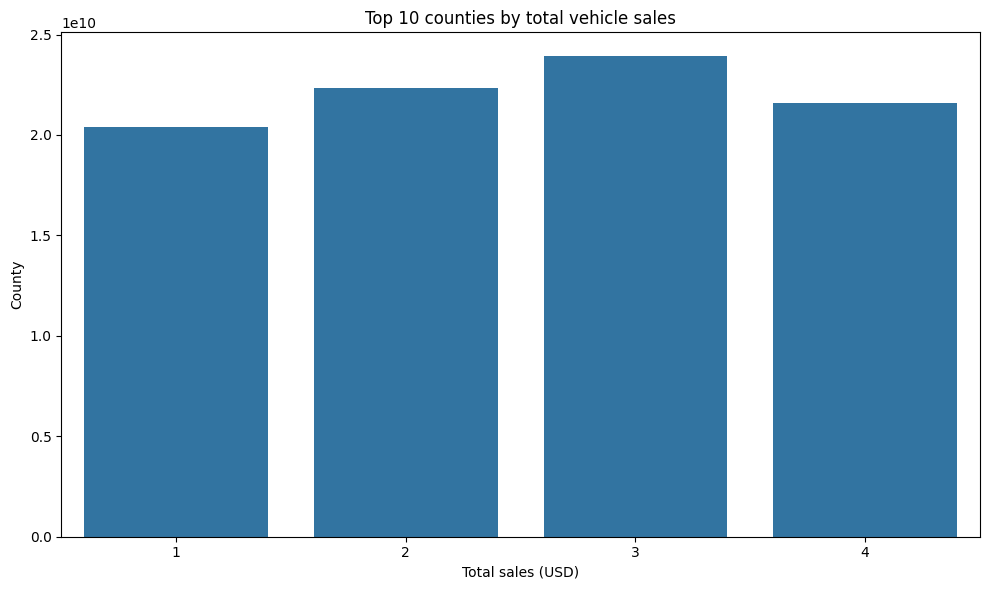

In [13]:
# 4.3 Top counties by total sales
county_sales = df.groupby('county')['sales'].sum().reset_index().sort_values('sales', ascending=False)
print("\nTop 10 counties by total sales:")
print(county_sales.head(10))

plt.figure(figsize=(10, 6))
sns.barplot(
    data=quarterly_sales,
    x='quarter',
    y='sales'
)
plt.title("Top 10 counties by total vehicle sales")
plt.xlabel("Total sales (USD)")
plt.ylabel("County")
plt.tight_layout()
plt.show()


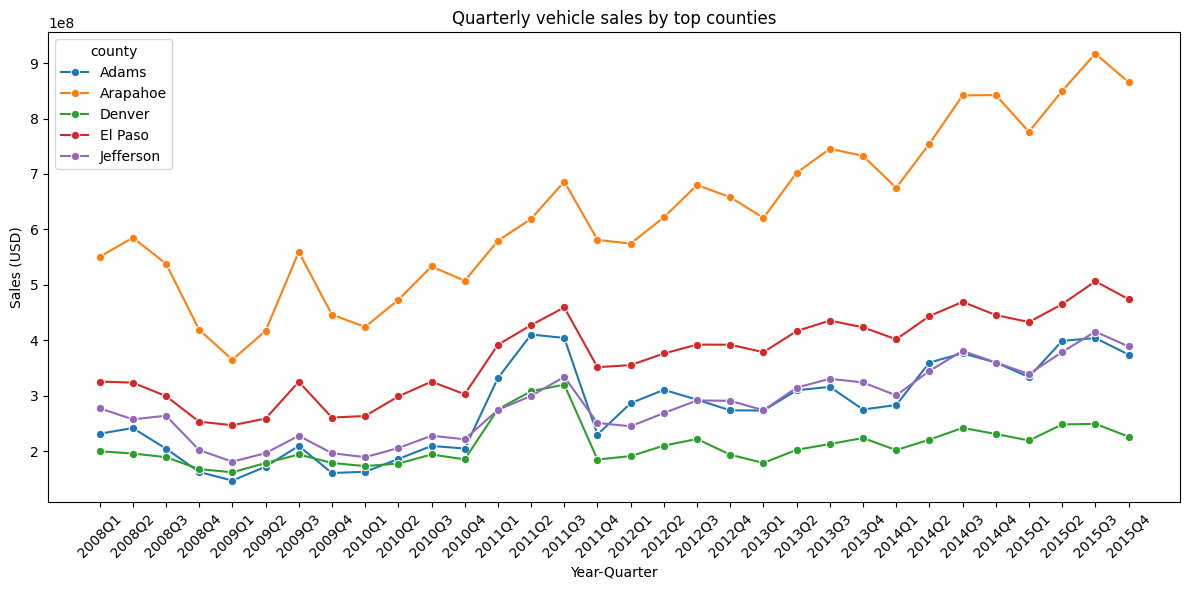

In [7]:
# =========================
# 5. Time series by county
# =========================

# Example: pick a few big counties to visualize over time
top_counties = county_sales.head(5)['county'].tolist()
df_top = df[df['county'].isin(top_counties)].copy()

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_top.sort_values(['year', 'quarter']),
    x='year_quarter',
    y='sales',
    hue='county',
    marker='o'
)
plt.title("Quarterly vehicle sales by top counties")
plt.xlabel("Year-Quarter")
plt.ylabel("Sales (USD)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [23]:
# ==========================================
# 6. Seasonality and growth pattern analysis
# ==========================================

# 6.1 Year-over-year growth by county
county_yearly = df.groupby(['county', 'year'])['sales'].sum().reset_index()
county_yearly['yoy_growth'] = county_yearly.groupby('county')['sales'].pct_change() * 100

print("\nYear-over-year growth sample:")
print(county_yearly.head(15))

# Visualize YoY growth for a specific county (e.g., Denver)


Year-over-year growth sample:
      county  year         sales  yoy_growth
0      Adams  2008   840,958,000         NaN
1      Adams  2009   689,914,000         -18
2      Adams  2010   763,549,000          11
3      Adams  2011 1,376,918,000          80
4      Adams  2012 1,164,347,000         -15
5      Adams  2013 1,174,812,000           1
6      Adams  2014 1,380,114,000          17
7      Adams  2015 1,511,503,000          10
8   Arapahoe  2008 2,092,912,000         NaN
9   Arapahoe  2009 1,787,961,000         -15
10  Arapahoe  2010 1,937,961,000           8
11  Arapahoe  2011 2,466,086,000          27
12  Arapahoe  2012 2,534,655,000           3
13  Arapahoe  2013 2,800,854,000          11
14  Arapahoe  2014 3,113,457,000          11


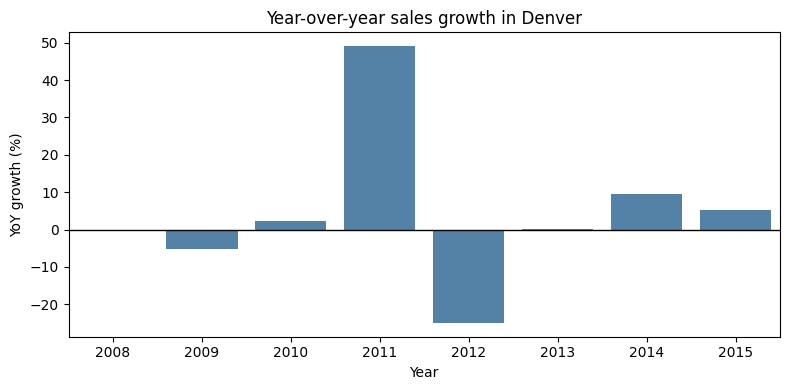

In [24]:
county_name = "Denver"  # change to any county in the dataset
denver_yoy = county_yearly[county_yearly['county'] == county_name]

plt.figure(figsize=(8, 4))
sns.barplot(data=denver_yoy, x='year', y='yoy_growth', color='steelblue')
plt.title(f"Year-over-year sales growth in {county_name}")
plt.xlabel("Year")
plt.ylabel("YoY growth (%)")
plt.axhline(0, color='black', linewidth=1)
plt.tight_layout()
plt.show()


Average sales per quarter:
   quarter       sales
0        1 163,014,768
1        2 178,746,352
2        3 191,319,472
3        4 171,192,270


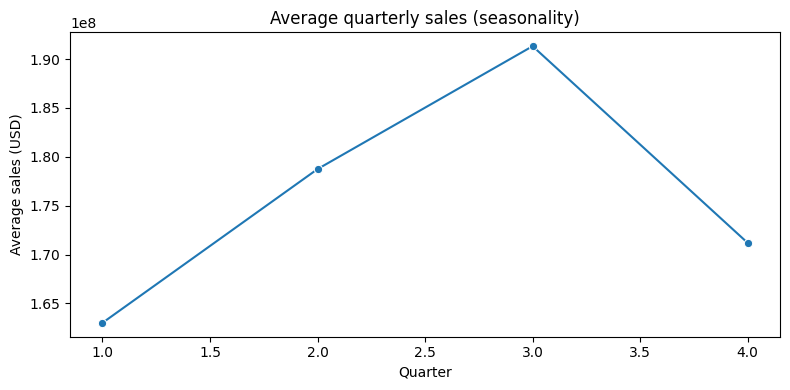

In [9]:

# 6.2 Seasonal pattern: average sales per quarter across years
seasonality = df.groupby('quarter')['sales'].mean().reset_index()
print("\nAverage sales per quarter:")
print(seasonality)

plt.figure(figsize=(8, 4))
sns.lineplot(data=seasonality, x='quarter', y='sales', marker='o')
plt.title("Average quarterly sales (seasonality)")
plt.xlabel("Quarter")
plt.ylabel("Average sales (USD)")
plt.tight_layout()
plt.show()


In [15]:
# ====================================
# 7. Simple predictive modeling example
# ====================================

# Goal: Predict total state-wide sales per quarter using time_index

state_quarter = df.groupby(['year', 'quarter'])['sales'].sum().reset_index()
state_quarter = state_quarter.sort_values(['year', 'quarter']).reset_index(drop=True)

# Create time index
state_quarter['time_index'] = np.arange(len(state_quarter))

X = state_quarter[['time_index']]
y = state_quarter['sales']

# Train-test split (e.g., last 4 quarters as test)
test_size = 4
X_train, X_test = X.iloc[:-test_size], X.iloc[-test_size:]
y_train, y_test = y.iloc[:-test_size], y.iloc[-test_size:]

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("\nTest performance (simple linear trend model):")
mse = mean_squared_error(y_test, y_pred)  # no squared argument
rmse = np.sqrt(mse)

print("MSE:", mse)
print("RMSE:", rmse)
print("R^2:", r2_score(y_test, y_pred))


Test performance (simple linear trend model):
MSE: 4.984197040594626e+16
RMSE: 223253153.18253908
R^2: -0.008996759860718129


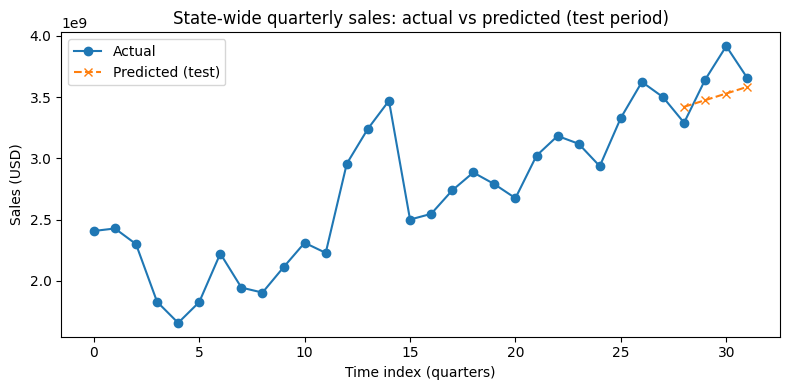

In [16]:
# Plot actual vs predicted for test period
plt.figure(figsize=(8, 4))
plt.plot(state_quarter['time_index'], state_quarter['sales'], label='Actual', marker='o')
plt.plot(X_test['time_index'], y_pred, label='Predicted (test)', marker='x', linestyle='--')
plt.title("State-wide quarterly sales: actual vs predicted (test period)")
plt.xlabel("Time index (quarters)")
plt.ylabel("Sales (USD)")
plt.legend()
plt.tight_layout()
plt.show()


In [22]:
# 7.1 Forecast next 4 quarters
future_periods = 4
last_index = state_quarter['time_index'].max()
future_time_index = np.arange(last_index + 1, last_index + 1 + future_periods)

# Use a DataFrame with the same column name as training
future_df = pd.DataFrame({'time_index': future_time_index})
future_pred = model.predict(future_df)

forecast_df = pd.DataFrame({
    'time_index': future_time_index,
    'forecast_sales': future_pred
})


Denver model test performance:
MSE: 175602027763003.75
RMSE: 13251491.529748783
R^2: -0.005572912713094569


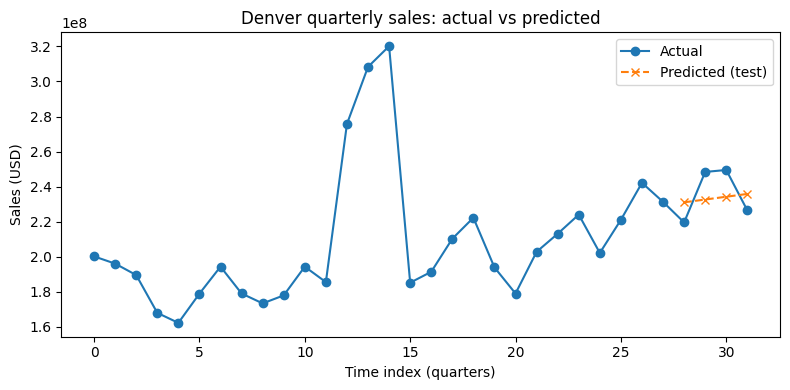

In [20]:

# =============================================
# 8. County-level model 
# =============================================

# Example: fit a separate linear trend for a single county

county_name = "Denver"  # change as needed
county_data = df[df['county'] == county_name].copy()
county_data = county_data.sort_values(['year', 'quarter'])

county_data['time_index'] = np.arange(len(county_data))

X_c = county_data[['time_index']]
y_c = county_data['sales']

test_size_c = 4
Xc_train, Xc_test = X_c.iloc[:-test_size_c], X_c.iloc[-test_size_c:]
yc_train, yc_test = y_c.iloc[:-test_size_c], y_c.iloc[-test_size_c:]

model_c = LinearRegression()
model_c.fit(Xc_train, yc_train)

yc_pred = model_c.predict(Xc_test)

print(f"\n{county_name} model test performance:")
mse_c = mean_squared_error(yc_test, yc_pred)   # no squared argument
rmse_c = np.sqrt(mse_c)

print("MSE:", mse_c)
print("RMSE:", rmse_c)
print("R^2:", r2_score(yc_test, yc_pred))
plt.figure(figsize=(8, 4))
plt.plot(county_data['time_index'], county_data['sales'], label='Actual', marker='o')
plt.plot(Xc_test['time_index'], yc_pred, label='Predicted (test)', marker='x', linestyle='--')
plt.title(f"{county_name} quarterly sales: actual vs predicted")
plt.xlabel("Time index (quarters)")
plt.ylabel("Sales (USD)")
plt.legend()
plt.tight_layout()
plt.show()


In [21]:
# ===============================
# 9. Saving processed datasets
# ===============================

# Save yearly and county-level aggregates for reporting / dashboarding
yearly_sales.to_csv("yearly_state_sales.csv", index=False)
county_sales.to_csv("total_sales_by_county.csv", index=False)
county_yearly.to_csv("county_yearly_sales_with_yoy.csv", index=False)
state_quarter.to_csv("state_quarterly_sales_with_time_index.csv", index=False)

print("\nDerived CSV files saved:")
print("- yearly_state_sales.csv")
print("- total_sales_by_county.csv")
print("- county_yearly_sales_with_yoy.csv")
print("- state_quarterly_sales_with_time_index.csv")


Derived CSV files saved:
- yearly_state_sales.csv
- total_sales_by_county.csv
- county_yearly_sales_with_yoy.csv
- state_quarterly_sales_with_time_index.csv
